# Figure for paper:
## Line profile variations, revisited


Author: Michael Gully-Santiago  
Date: Feb 16, 2023

Simple model fit to He lines

In [1]:
import numpy as np
import pandas as pd
import os
import glob
from astropy.io import fits
import warnings
import matplotlib.pyplot as plt
import astropy.units as u
from muler.hpf import HPFSpectrum
import seaborn as sns

from specutils.fitting import fit_continuum
from astropy.modeling import models

from astropy.time import Time
import lightkurve as lk
from tqdm.notebook import tqdm

%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set_context('paper', font_scale=1.2)

from pandas.core.common import SettingWithCopyWarning

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
warnings.filterwarnings("ignore", message="Model is linear in parameters")

In [2]:
plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'

## Featch metadata table

In [3]:
import pyarrow.feather as feather

In [4]:
df = feather.read_feather('../../data/HPF/HAT_P_67_log.feather')

## Assign the orbital phase

Let's compute the normalized phase shifted so that the transit midpoint always occurs at zero while also seeing the light curve before and after the midpoint.

$$\phi=\frac{\mod(t-T_c+\frac{P}{2}\;,P)}{P} -0.5$$ 

In [5]:
target_name = 'HAT-P-67b'
orbital_period = 4.81010250
t_c = 2455961.38467
t_c_btjd = t_c - 2457000.0 #neg value means discovered before TESS
t_14_hours = 6.989 # transit duration in hours
t_14_days = t_14_hours/24.0
t_14_orb_phase = t_14_days / orbital_period

Assign the "campaigns" surrounding individual transits.

In [6]:
from astropy.time import Time
import astropy.units as u

## Post-process the spectra
Apply the same method to each spectrum.  We will define some continuum indices to flatten to.

In [7]:
blue_limits = (10826.5*u.Angstrom, 10827.5*u.Angstrom)
red_limits = (10839.2*u.Angstrom, 10840.2*u.Angstrom)

window = [blue_limits, red_limits]

In [8]:
def flatten_to_regions(spec, windows, polynomial_order=None):
    """Flatten a spectrum to featureless continuum input regions
    
    Parameters:
    ----------
    spec (Spectrum1D-like):
        A spectrum to be flattened
    window (list of tuples):
        A list of pairs of boundaries at which the straight line will be computed
    polynomial_order (int):
        The polynomial order of the fit (defaults to 1-- straight line)
    """
    if polynomial_order is None:
        polynomial_order = 1
    linear_model = models.Chebyshev1D(polynomial_order)
    continuum_func = fit_continuum(spec, window=windows, model=linear_model)
    return spec/continuum_func(spec.wavelength)

In [9]:
fn = df.full_path.values[0]

In [10]:
spec_list = []
for fn in tqdm(df.full_path.values):
    spec_raw = HPFSpectrum(file=fn, order=19)
    spec =  spec_raw.sky_subtract(method='vector')\
                    .remove_nans()\
                    .trim_edges()\
                    .deblaze()\
                    .mask_tellurics(threshold=0.95, dilation=3)\
                    .barycentric_correct().normalize()
    spec = spec.rv_shift(+1.4)
    spec = flatten_to_regions(spec, window)
    spec_list.append(spec)

  0%|          | 0/152 [00:00<?, ?it/s]

In [11]:
len(spec_list)

152

In [12]:
feature_indices = (10832.3, 10834.2)

In [13]:
len(spec_list)

152

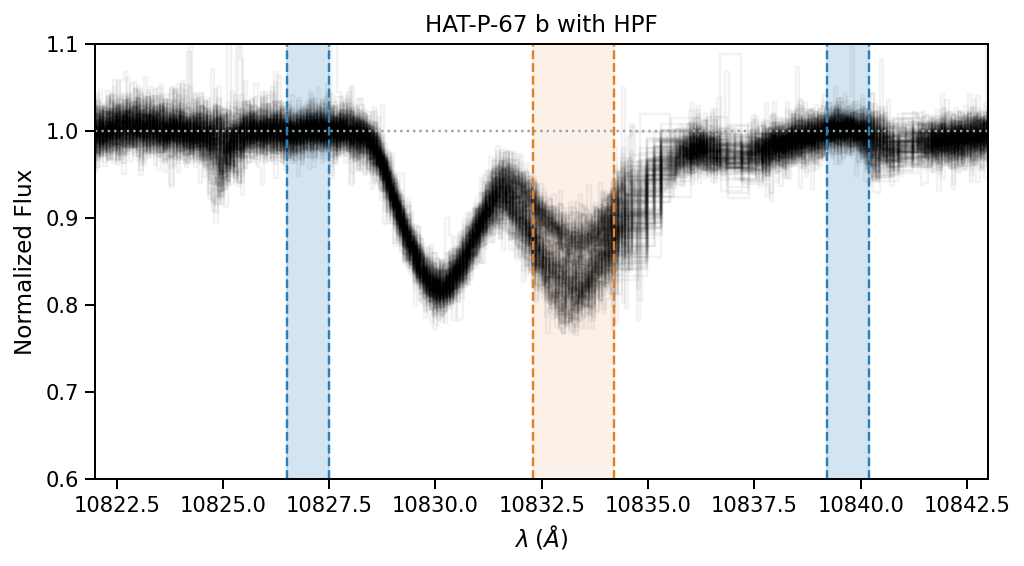

In [14]:
fig, ax = plt.subplots(figsize=(8, 4))

for spec in spec_list:
    spec.plot(ax=ax, ylo=0, color='k', alpha=0.05)


ax.set_xlim(10822, 10843)
ax.axhline(1.0, linestyle='dotted', color='#95a5a6')

ax.axvline(blue_limits[0].value, linestyle='dashed', color='#2980b9')
ax.axvline(blue_limits[1].value, linestyle='dashed', color='#2980b9')
ax.fill_between([x.value for x in blue_limits], [2, 2], alpha=0.2, color='#2980b9')

ax.axvline(feature_indices[0], linestyle='dashed', color='#e67e22')
ax.axvline(feature_indices[1], linestyle='dashed', color='#e67e22')
ax.fill_between(feature_indices, [2, 2], alpha=0.1, color='#e67e22', zorder=0)

ax.axvline(red_limits[0].value, linestyle='dashed', color='#2980b9')
ax.axvline(red_limits[1].value, linestyle='dashed', color='#2980b9')
ax.fill_between([x.value for x in red_limits], [2, 2], alpha=0.2, color='#2980b9')

ax.set_xlabel('$\lambda\;(\AA)$')
ax.set_ylabel('Normalized Flux')
ax.set_title('HAT-P-67 b with HPF')

ax.set_ylim(0.6, 1.1)
plt.savefig('../../figures/HAT_P_67b_He_spectrum.png', bbox_inches='tight', dpi=300);

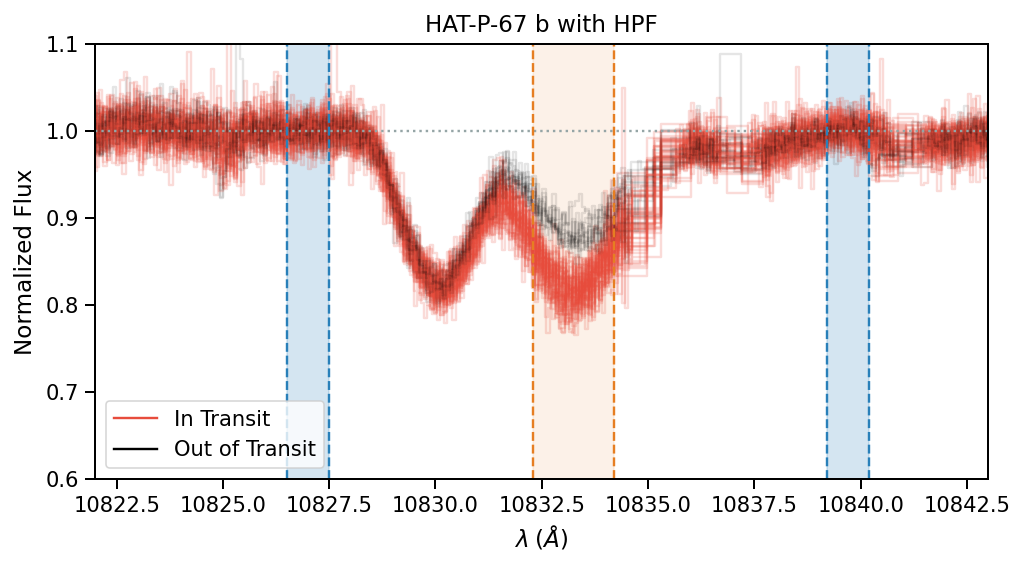

In [15]:
fig, ax = plt.subplots(figsize=(8, 4))

for i, spec in enumerate(spec_list):
    if df.iloc[i].in_transit_flag:
        spec.plot(ax=ax, ylo=0, color='#e74c3c', alpha=0.2)
    elif df.iloc[i].normalized_phase > 0.3:
        spec.plot(ax=ax, ylo=0, color='k', alpha=0.1)
    #elif (df.iloc[i].normalized_phase < -0.05) &  (df.iloc[i].normalized_phase > -0.3):
    #    spec.plot(ax=ax, ylo=0, color='#3498db', alpha=0.2, zorder=10)
    
(spec*0.0).plot(ax=ax, color='#e74c3c', alpha=1, label='In Transit')
(spec*0.0).plot(ax=ax, color='k', alpha=1, label='Out of Transit')
#(spec*0.0).plot(ax=ax, color='#3498db', alpha=1, label='Extended Ingress')


ax.set_xlim(10822, 10843)
ax.axhline(1.0, linestyle='dotted', color='#95a5a6')

ax.axvline(blue_limits[0].value, linestyle='dashed', color='#2980b9')
ax.axvline(blue_limits[1].value, linestyle='dashed', color='#2980b9')
ax.fill_between([x.value for x in blue_limits], [2, 2], alpha=0.2, color='#2980b9')

ax.axvline(feature_indices[0], linestyle='dashed', color='#e67e22')
ax.axvline(feature_indices[1], linestyle='dashed', color='#e67e22')
ax.fill_between(feature_indices, [2, 2], alpha=0.1, color='#e67e22', zorder=0)

ax.axvline(red_limits[0].value, linestyle='dashed', color='#2980b9')
ax.axvline(red_limits[1].value, linestyle='dashed', color='#2980b9')
ax.fill_between([x.value for x in red_limits], [2, 2], alpha=0.2, color='#2980b9')

ax.set_xlabel('$\lambda\;(\AA)$')
ax.set_ylabel('Normalized Flux')
ax.set_title('HAT-P-67 b with HPF')

plt.legend()

ax.set_ylim(0.6, 1.1)
plt.savefig('../../figures/HAT_P_67b_He_spectrum_transit.png', bbox_inches='tight', dpi=300);

## Get line center positions and widths

fit a model to these spectra:

In [16]:
spec = spec_list[0]

In [17]:
from scipy.special import voigt_profile

In [18]:
wl_vacuum = [10833.470120589382, 10833.380094831637, 10832.219762843133]

In [19]:
def line_model(baseline, lam_0, ln_amp, ln_sigma, ln_gamma, wavelength=None):
    amp, sigma, gamma = np.exp(ln_amp), np.exp(ln_sigma), np.exp(ln_gamma)
    '''fit a Voigt profile with a GP'''
    wl_vector = wavelength - lam_0
    return baseline - amp * voigt_profile(wl_vector, sigma, gamma)

In [20]:
def joint_model(theta, wavelength=None):
    baseline, lam_01, ln_amp1, ln_sigma1, ln_gamma1, \
    lam_02, ln_amp2, ln_sigma2, ln_gamma2 = theta
    '''Fit two nearby lines'''
    model1 = line_model(baseline, lam_01, ln_amp1, ln_sigma1, ln_gamma1, wavelength=wavelength)
    model2 = line_model(0, lam_02, ln_amp2, ln_sigma2, ln_gamma2, wavelength=wavelength)
    return model1+model2

(10827.0, 10838.0)

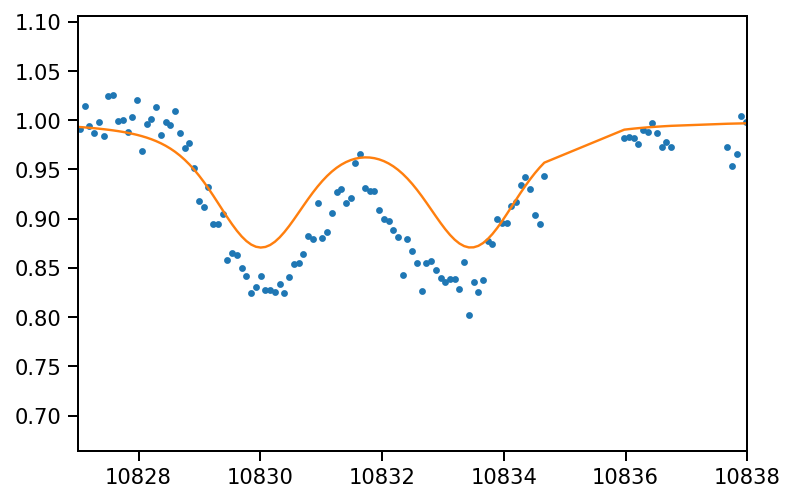

In [21]:
flux = joint_model([1.0, 10830.0, np.log(0.3), np.log(0.5), np.log(0.5),\
                    wl_vacuum[0], np.log(0.3), np.log(0.5), np.log(0.5)],\
                   wavelength=spec.wavelength.value) 

plt.plot(spec.wavelength.value, spec.flux.value, '.')
plt.plot(spec.wavelength.value, flux)
plt.xlim(10827, 10838)

In [22]:
mask = (spec.wavelength.value > 10827) & (spec.wavelength.value < 10838)
spec = spec.apply_boolean_mask(mask)

In [23]:
theta_init = np.array([1.0, 10830.05, np.log(0.318), np.log(0.716), np.log(0.017),\
                    10833.279, np.log(0.684), np.log(0.107), np.log(1.27)])

In [24]:
def ln_prior(theta):
    baseline, lam_01, ln_amp1, ln_sigma1, ln_gamma1, \
    lam_02, ln_amp2, ln_sigma2, ln_gamma2 = theta
    if (np.exp(ln_sigma1) < -5) | (ln_gamma1 < -5) | (ln_sigma2 < -5) | (ln_gamma2 < -5) |\
        (ln_sigma1 > 5) | (ln_gamma1 > 5) | (ln_sigma2 > 5) | (ln_gamma2 > 5):
        return -np.inf
    else:
        return 0.0

In [25]:
def ln_prob(theta):
    flux_model = joint_model(theta, wavelength=spec.wavelength.value) 
    residual = spec.flux.value - flux_model
    scaled_resid = residual/spec.uncertainty.array
    prior = ln_prior(theta)
    return -0.5*np.sum(scaled_resid*scaled_resid) + prior

In [26]:
ndim = len(theta_init)
nwalkers = 40
ndim, nwalkers

(9, 40)

In [27]:
theta_init

array([ 1.00000000e+00,  1.08300500e+04, -1.14570390e+00, -3.34075112e-01,
       -4.07454193e+00,  1.08332790e+04, -3.79797361e-01, -2.23492644e+00,
        2.39016900e-01])

In [28]:
scales = [0.01, 1e-5, 0.1, 0.01, 0.1, 1e-5, 0.1, 0.01, 0.01]

In [29]:
perturbations = np.vstack([np.random.normal(scale=scale, size=nwalkers) for scale in scales])

In [30]:
p0 = theta_init + perturbations.T

In [31]:
import emcee

In [32]:
labels = ["const", "lam1", "amp1", 'sigma1', 'gamma1', 'lam2', 'amp2', 'sigma2', 'gamma2']

In [33]:
def transform_samples(samples):
    '''Convert samples to back to physical units'''    
    samples_absolute = np.copy(samples)
    # parameters 0, 1, 5 stay the same.
    
    samples_absolute[:,:, 2:5] = np.exp(samples[:,:, 2:5])
    samples_absolute[:,:, 6:] = np.exp(samples[:,:, 6:])
    return samples_absolute

In [34]:
def transform_flat_samples(samples):
    '''Convert samples to back to physical units'''    
    samples_absolute = np.copy(samples)
    # parameters 0, 1, 5 stay the same.
    
    samples_absolute[:, 2:5] = np.exp(samples[:, 2:5])
    samples_absolute[:, 6:] = np.exp(samples[:, 6:])
    return samples_absolute

In [35]:
from tqdm.notebook import tqdm_notebook

In [39]:
labels_out = sorted([label+'_lo' for label in labels] + labels + [label+'_hi' for label in labels])

df_out = pd.DataFrame()
df_out

""


In [40]:
for j, spec in tqdm_notebook(enumerate(spec_list),display=True, total=len(spec_list)):
    mask = (spec.wavelength.value > 10827) & (spec.wavelength.value < 10838)
    spec = spec.apply_boolean_mask(mask)
    
    sampler = emcee.EnsembleSampler(nwalkers, ndim, ln_prob)
    output = sampler.run_mcmc(p0, 2000, progress=False)
    
    flat_samples = sampler.get_chain(discard=1000, thin=15, flat=True)
    flat_abs_samples = transform_flat_samples(flat_samples)
    
    dict_out = {}
    for i in range(ndim):
        mcmc = np.percentile(flat_abs_samples[:, i], [16, 50, 84])
        q = np.diff(mcmc)
        dict_out[labels[i]] = mcmc[1]
        dict_out[labels[i]+'_lo']= q[0]
        dict_out[labels[i]+'_hi']= q[1]
    df_out = pd.concat([df_out, pd.DataFrame(dict_out, index=[j])])
    df_out.to_csv('../../data/HPF/He10830_MCMC_fits_two_lines.csv', index=False)

  0%|          | 0/152 [00:00<?, ?it/s]

(0.0, 2.0)

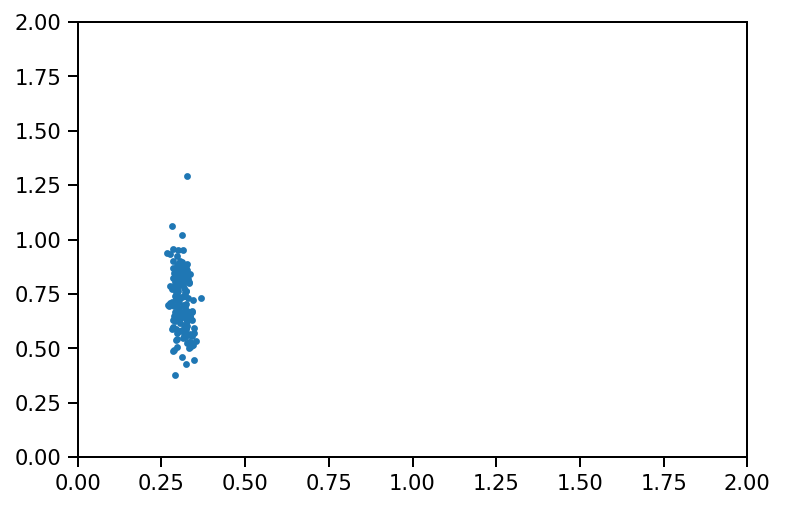

In [41]:
plt.plot(df_out.amp1, df_out.amp2, '.')
plt.xlim(0, 2)
plt.ylim(0, 2)

(0.0, 5.0)

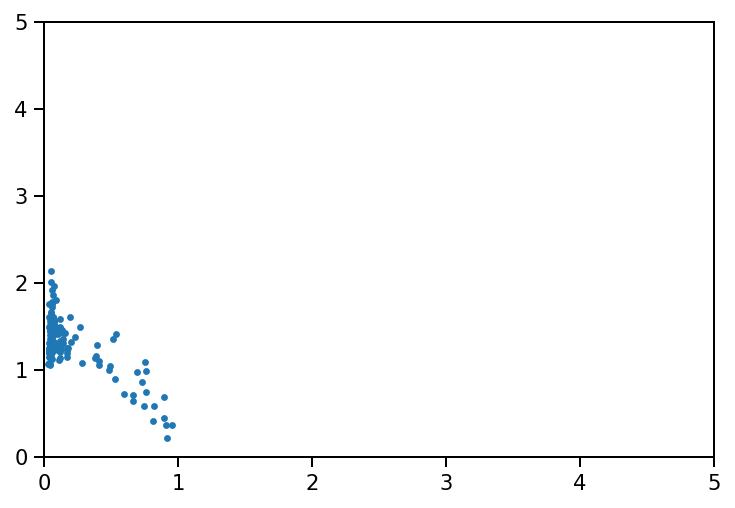

In [42]:
plt.plot(df_out.sigma2, df_out.gamma2, '.')
plt.xlim(0, 5)
plt.ylim(0, 5)

(10829.0, 10834.0)

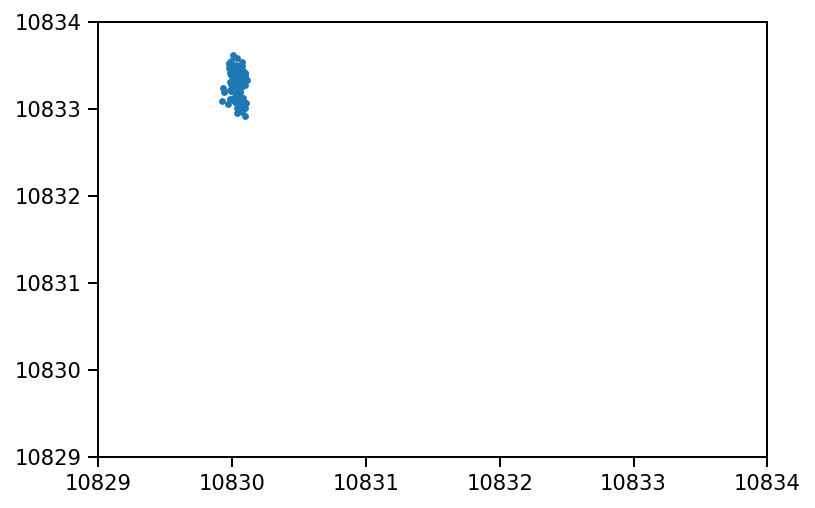

In [43]:
plt.plot(df_out.lam1, df_out.lam2, '.')
plt.xlim(10829, 10834)
plt.ylim(10829, 10834)

In [44]:
len(df_out)

152

In [45]:
len(df)

152

In [46]:
df['center_wl'] = df_out.lam2

In [65]:
0.02

0.02

In [48]:
df_out.iloc[0]

const            1.004528
const_lo         0.003088
const_hi         0.003023
lam1         10830.061859
lam1_lo          0.019739
lam1_hi          0.021673
amp1             0.284053
amp1_lo          0.009032
amp1_hi          0.009840
sigma1           0.685491
sigma1_lo        0.021783
sigma1_hi        0.021520
gamma1           0.017488
gamma1_lo        0.008537
gamma1_hi        0.021771
lam2         10833.123920
lam2_lo          0.026757
lam2_hi          0.023861
amp2             0.629447
amp2_lo          0.049293
amp2_hi          0.036114
sigma2           0.106628
sigma2_lo        0.087970
sigma2_hi        0.254866
gamma2           1.117609
gamma2_lo        0.157846
gamma2_hi        0.072342
Name: 0, dtype: float64

In [60]:
df_out.lam1_hi.describe()

count    152.000000
mean       0.019925
std        0.005004
min        0.012435
25%        0.016209
50%        0.019236
75%        0.022327
max        0.044426
Name: lam1_hi, dtype: float64

In [81]:
df_out.lam2.describe()

count      152.000000
mean     10833.294607
std          0.139083
min      10832.920551
25%      10833.217983
50%      10833.307287
75%      10833.397613
max      10833.621762
Name: lam2, dtype: float64

In [ ]:
plt.scatter(df_out.lam1, df.normalized_phase, s=df_out.amp1*50, ec='w')

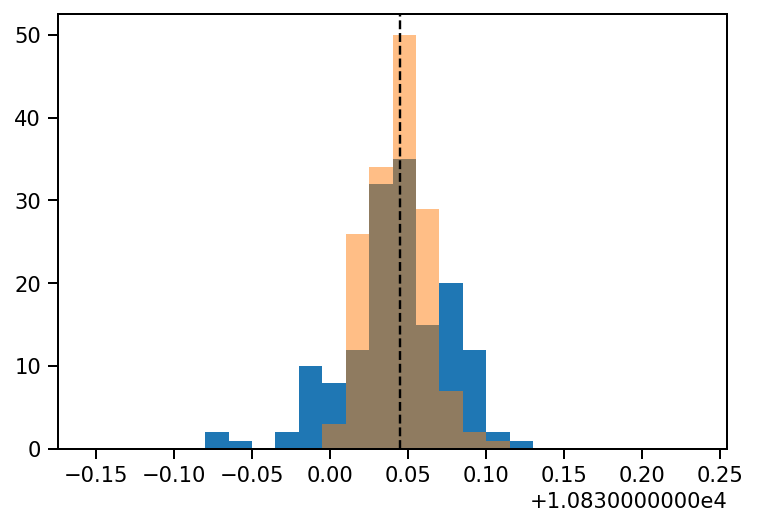

In [80]:
plt.hist(df_out.lam1, 
         bins=np.arange(10830.045-0.2, 10830.045+0.2, 0.015));
plt.hist(np.random.normal(loc=10830.045, scale=0.02, size=152), 
         bins=np.arange(10830.045-0.2, 10830.045+0.2, 0.015), alpha=0.5);
plt.axvline(10830.045, color='k', linestyle='dashed')

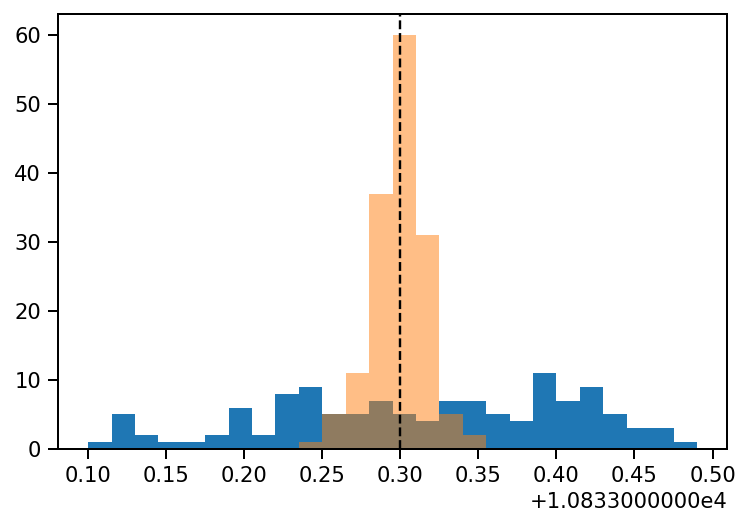

In [82]:
plt.hist(df_out.lam2, 
         bins=np.arange(10833.30-0.2, 10833.30+0.2, 0.015));
plt.hist(np.random.normal(loc=10833.30, scale=0.02, size=152), 
         bins=np.arange(10833.30-0.2, 10833.30+0.2, 0.015), alpha=0.5);
plt.axvline(10833.30, color='k', linestyle='dashed')

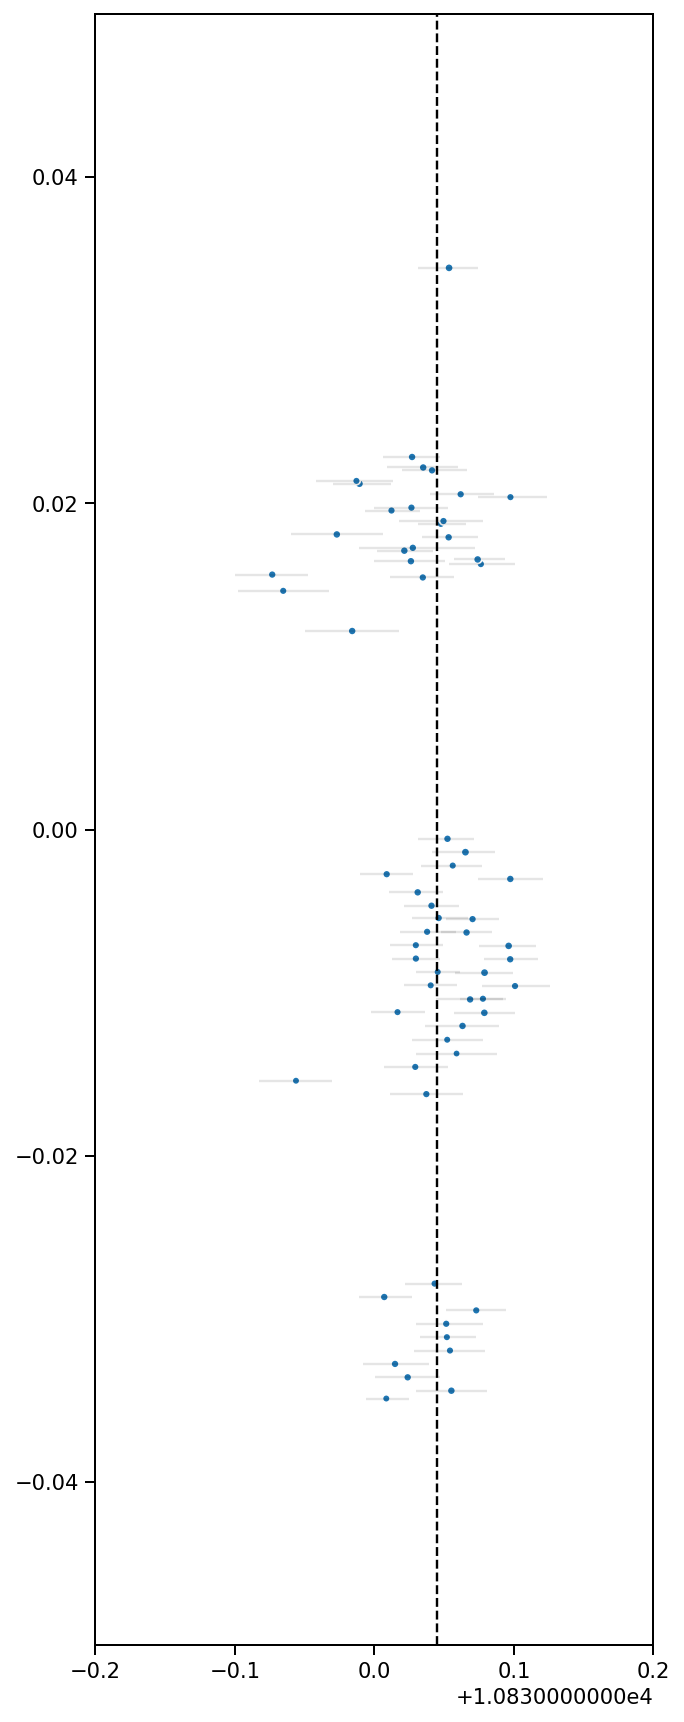

In [92]:
plt.figure(figsize=(5, 15))
plt.errorbar(df_out.lam1, df.normalized_phase, xerr=(df_out.lam1_lo, df_out.lam1_hi),
             linestyle='none', color='k', alpha=0.1)
plt.scatter(df_out.lam1, df.normalized_phase, s=df_out.amp1*50, ec='w')


#plt.ylim(-0.2, 0.1)
plt.axvline(10833.4, color='k')
plt.xlim(10829.8, 10830.2)
plt.ylim(-0.05, 0.05)
plt.axvline(10830.045, color='k', linestyle='dashed')

(-0.05, 0.05)

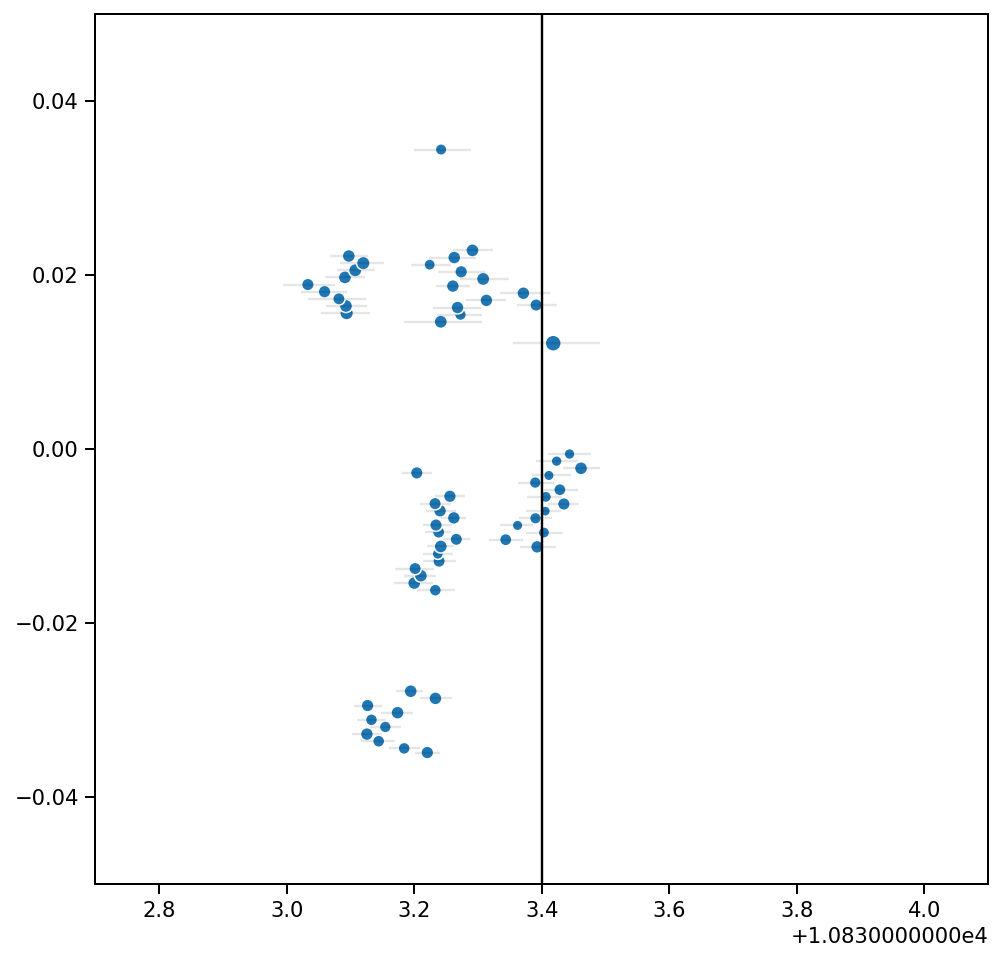

In [119]:
plt.figure(figsize=(8, 8))
plt.errorbar(df_out.lam2, df.normalized_phase, xerr=(df_out.lam2_lo, df_out.lam2_hi),
             linestyle='none', color='k', alpha=0.1)
plt.scatter(df_out.lam2, df.normalized_phase, s=df_out.amp2*50, ec='w')


#plt.ylim(-0.2, 0.1)
plt.axvline(10833.4, color='k')
plt.xlim(10833.4-0.7, 10833.4+0.7)
plt.ylim(-0.05, 0.05)

In [169]:
rate = (150.0 * u.km/u.s)

In [170]:
distance = rate * 1.0*u.day

In [171]:
a_AU = 0.065*u.AU

In [172]:
extent = 0.2*2*np.pi*a_AU

In [173]:
(distance/extent).to(u.dimensionless_unscaled)

<Quantity 1.06061159>

(10832.699999999999, 10834.1)

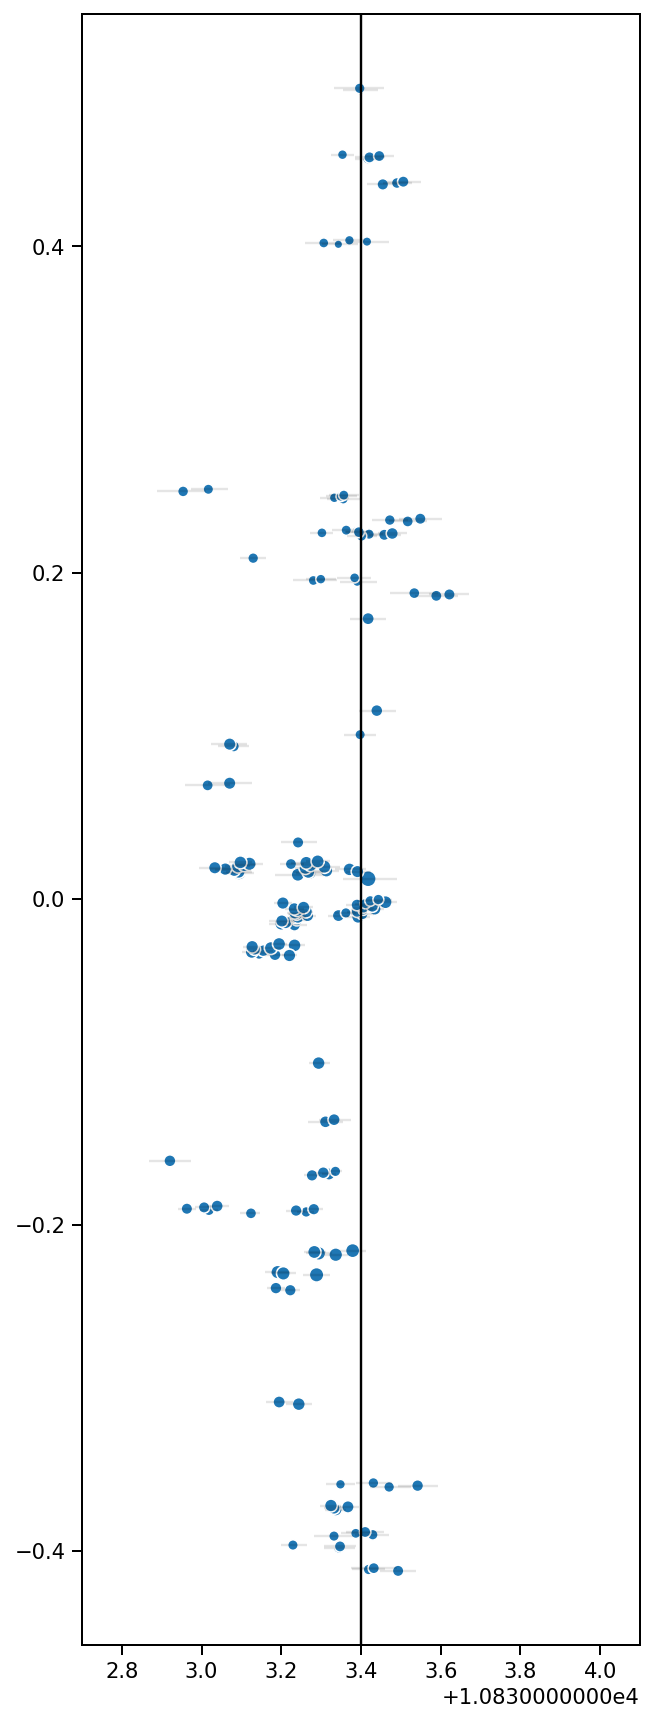

In [118]:
plt.figure(figsize=(5, 15))
plt.errorbar(df_out.lam2, df.normalized_phase, xerr=(df_out.lam2_lo, df_out.lam2_hi),
             linestyle='none', color='k', alpha=0.1)
plt.scatter(df_out.lam2, df.normalized_phase, s=df_out.amp2*50, ec='w')


#plt.ylim(-0.2, 0.1)
plt.axvline(10833.4, color='k')
plt.xlim(10833.4-0.7, 10833.4+0.7)

In [102]:
import astropy.constants as const

In [107]:
velocities = (df_out.lam2-10833.4).values/10833.4 * const.c.to(u.km/u.s)

(-20.0, 20.0)

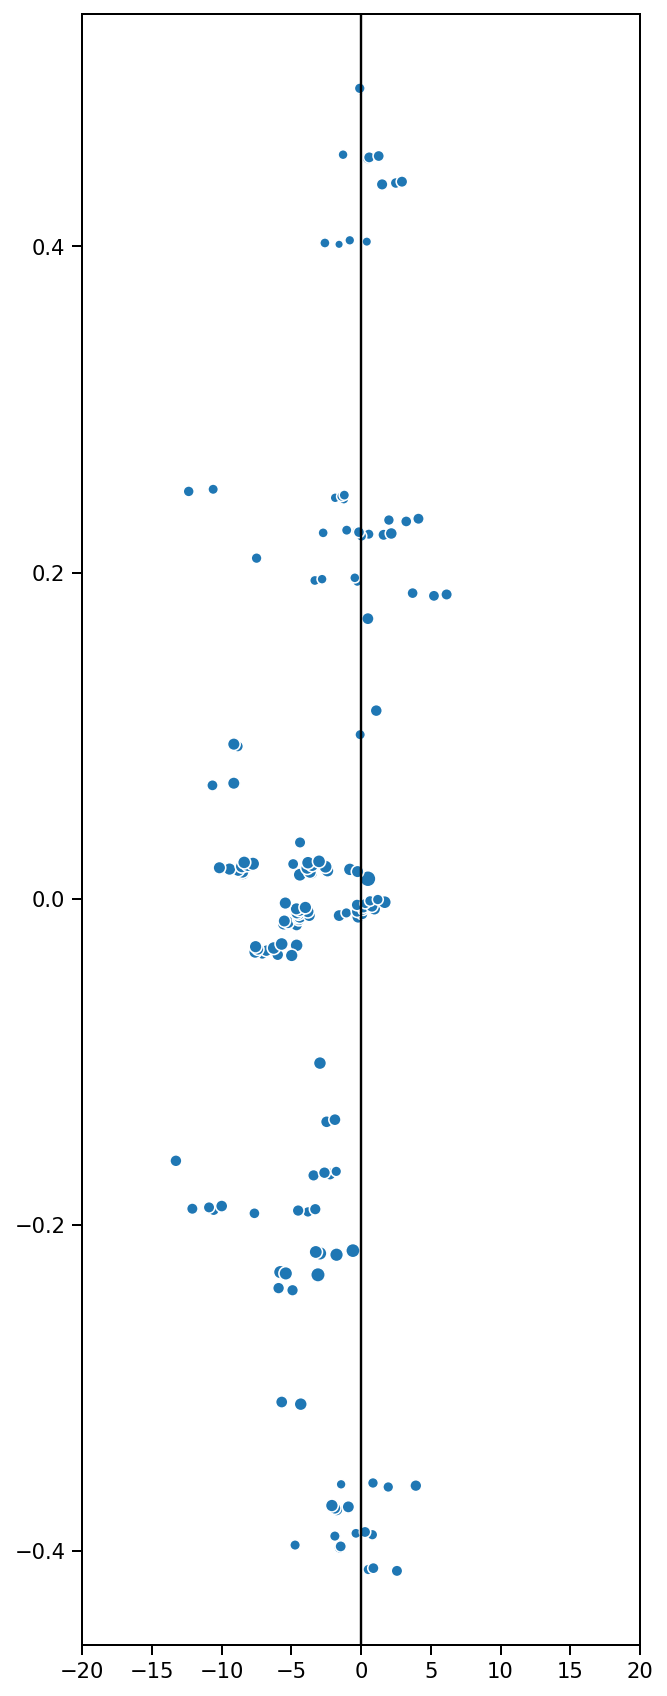

In [116]:
plt.figure(figsize=(5, 15))
plt.scatter(velocities, df.normalized_phase, s=df_out.amp2*50, ec='w')


#plt.ylim(-0.2, 0.1)
plt.axvline(0, color='k')
plt.xlim(-20, 20)

(10829.0, 10834.0)

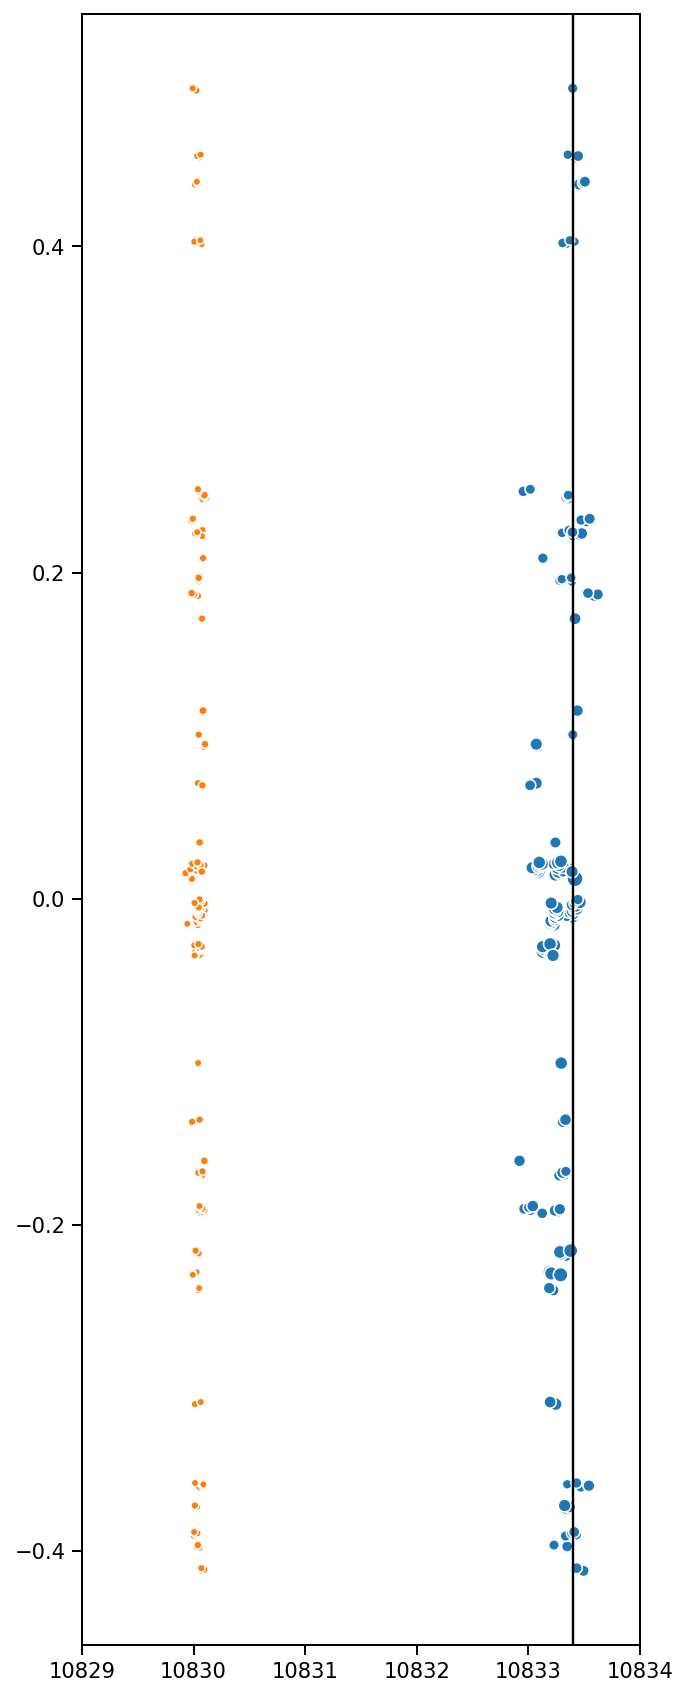

In [52]:
plt.figure(figsize=(5, 15))
plt.scatter(df.center_wl, df.normalized_phase, s=df_out.amp2*50, ec='w')
plt.scatter(df_out.lam1, df.normalized_phase, s=df_out.amp1*50, ec='w')

#plt.ylim(-0.2, 0.1)
plt.axvline(10833.4, color='k')
plt.xlim(10829, 10834)

Re-initialize to the a draw from the first trial to shed some hysteresis of the first coarse initialization.

In [40]:
samples = sampler.get_chain()

p0 = samples[-1, 13, :] + perturbations.T

In [41]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, ln_prob)
output = sampler.run_mcmc(p0, 5000, progress=True)

100%|██████████████████████████████████████| 5000/5000 [00:31<00:00, 160.56it/s]


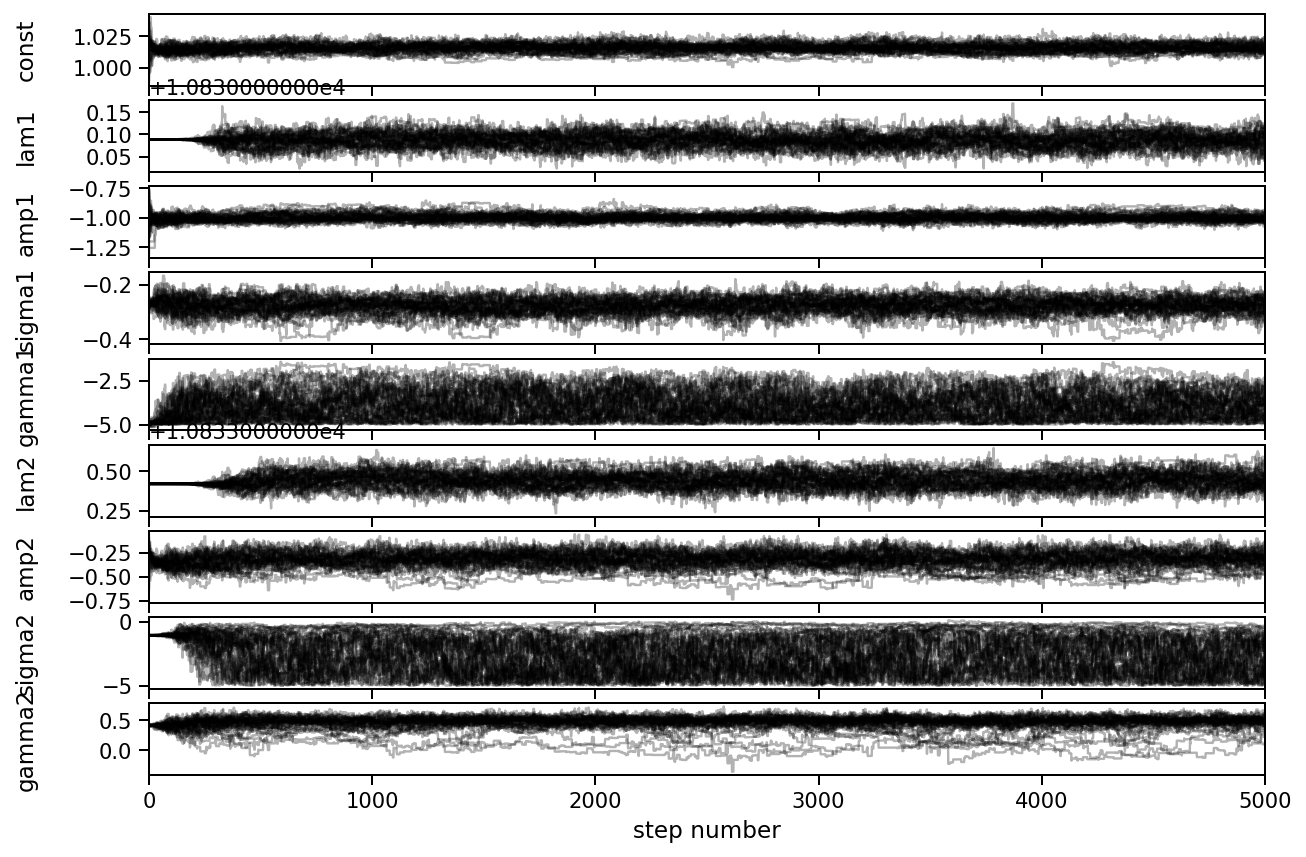

In [42]:
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [43]:
samples_absolute = transform_samples(samples)

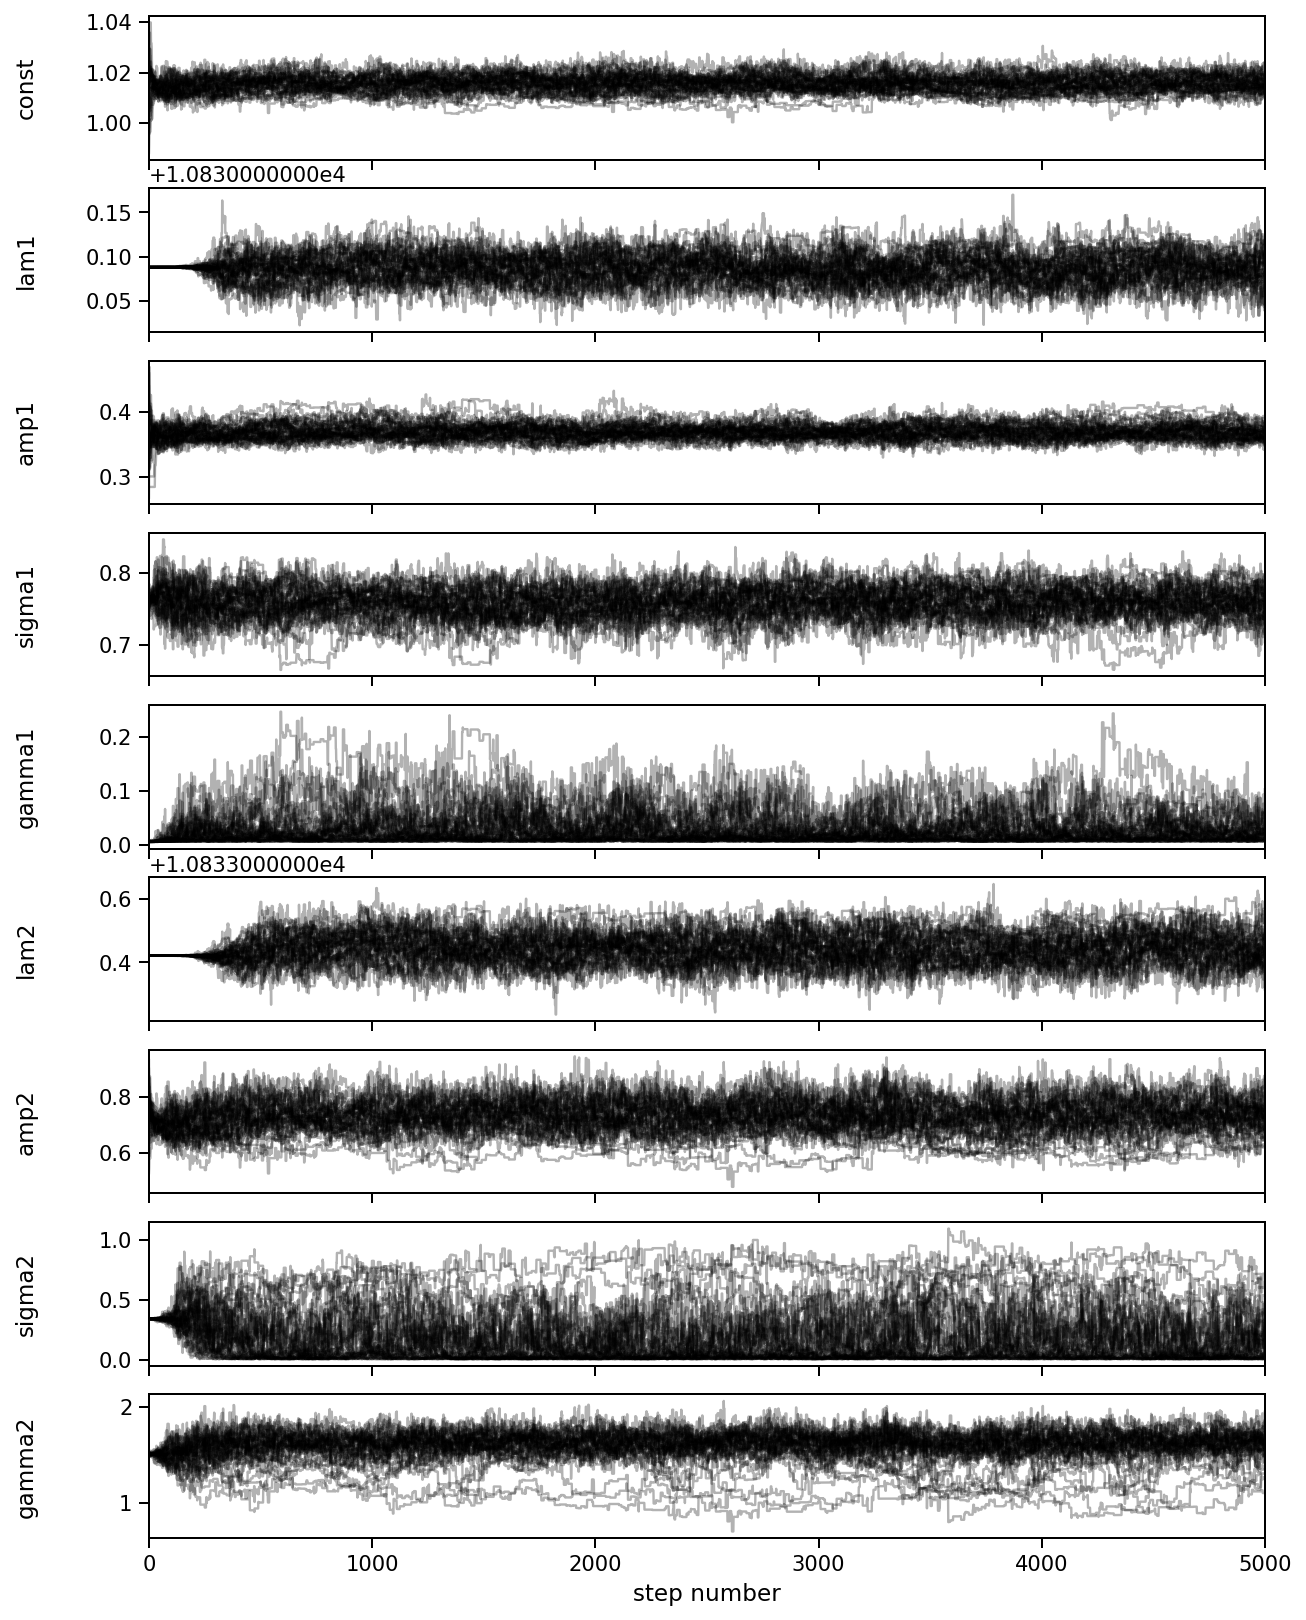

In [44]:
fig, axes = plt.subplots(ndim, figsize=(10, 14), sharex=True)
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples_absolute[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples_absolute))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

(10827.0, 10838.0)

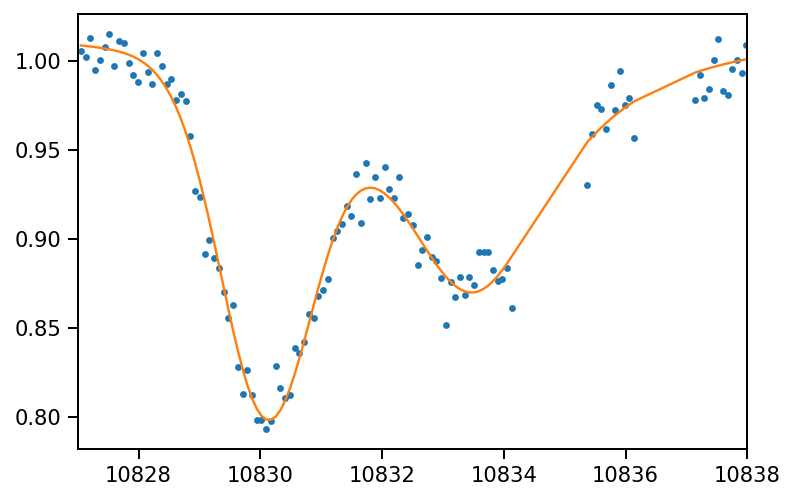

In [45]:
flux_model = joint_model(samples[-1, 13, :], wavelength=spec.wavelength.value) 

plt.plot(spec.wavelength.value, spec.flux.value, '.')
plt.plot(spec.wavelength.value, flux_model)
plt.xlim(10827, 10838)

Ok, good enough for our purposes!